## Data comparison

This notebook aims to compare the extracted data from various datasets against ground truth to evaluate the performance of these datasets and assessint their suitability for future studies.

Datasets are required to be stored in csv format with "Datetime", "location 1", "location 2" etc columns




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import pearsonr, genextreme, ks_2samp
from scipy.optimize import fsolve
import math

warnings.filterwarnings('ignore')


Common functions

In [2]:
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'DJF'  # December, January, February
    elif month in [3, 4, 5]:
        return 'MAM'  # March, April, May
    elif month in [6, 7, 8]:
        return 'JJA'  # June, July, August
    elif month in [9, 10, 11]:
        return 'SON'  # September, October, November

# Split Season_Year into season and year for proper sorting
def season_to_month(season):
    if season == 'DJF':
        return 1
    elif season == 'MAM':
        return 4
    elif season == 'JJA':
        return 7
    elif season == 'SON':
        return 10

# Define a function to process and extract relevant columns for each dataset
def extract_relevant_columns(data, dataset_name):
    data = data.dropna(subset=['Tengah', 'Changi', 'Choa Chu Kang'])
    data['Year'] = data['Season_Year'].str[-4:].astype(int)
    data['Season'] = data['Season_Year'].str[:3]
    data['Month'] = data['Season'].apply(season_to_month)
    data['Datetime'] = pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))
    data['Dataset'] = dataset_name
    return data[['Season_Year', 'Tengah', 'Changi', 'Choa Chu Kang', 'Dataset']]
        
# Function to calculate KGE
def calculate_kge(simulated, observed):
    r = np.corrcoef(simulated, observed)[0, 1]
    alpha = np.std(simulated) / np.std(observed)
    beta = np.mean(simulated) / np.mean(observed)
    kge = 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)
    return kge

# Calculate metrics for each location
def calculate_metrics(location):
    results = []
    
    # Align data on the same time index
    combined_grouped = pd.concat([
        rain_gauge_grouped[['Season_Year', location]].set_index('Season_Year'),
        ERA5_Land_grouped[['Season_Year', location]].set_index('Season_Year'),
        IMERG_grouped[['Season_Year', location]].set_index('Season_Year'),
        NEA_grouped[['Season_Year', location]].set_index('Season_Year'),
        CMORPH_grouped[['Season_Year', location]].set_index('Season_Year'),
        ERA5_Reanalysis_grouped[['Season_Year', location]].set_index('Season_Year')
    ], axis=1, keys=['Rain Gauge', 'ERA5 Land', 'IMERG', 'NEA', 'CMORPH', 'ERA5 Reanalysis']).dropna()

    for dataset in ['Rain Gauge', 'ERA5 Land', 'IMERG', 'CMORPH', 'ERA5 Reanalysis']:
        simulated = combined_grouped[dataset][location]
        observed = combined_grouped['NEA'][location]

        mae = np.mean(np.abs(simulated - observed))
        correlation, _ = pearsonr(simulated, observed)
        kge = calculate_kge(simulated, observed)

        results.append({
            'Dataset': dataset,
            'MAE': mae,
            'Correlation': correlation,
            'KGE': kge
        })

    return pd.DataFrame(results)

# Group by Season_Year and calculate the sum of precipitation for each location
def group_by_season_year(data):
    grouped = data.groupby('Season_Year').sum(numeric_only=True).reset_index()
    grouped['Datetime'] = pd.to_datetime(grouped['Season_Year'].str[-4:] + '-' + grouped['Season_Year'].str[:3].map({'DJF': '12', 'MAM': '03', 'JJA': '06', 'SON': '09'}))
    grouped = grouped.sort_values(by='Datetime')
    return grouped

# Define a function to process and extract relevant columns for each dataset
def process_dataset(data, dataset_name):
    data = data.dropna(subset=['Tengah', 'Changi', 'Choa Chu Kang'])
    data['Year'] = data['Season_Year'].str[-4:].astype(int)
    data['Season'] = data['Season_Year'].str[:3]
    data['Month'] = data['Season'].apply(season_to_month)
    data['Datetime'] = pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))
    data['Dataset'] = dataset_name
    return data[['Season', 'Tengah', 'Changi', 'Choa Chu Kang', 'Dataset']]


Dataset loading and processing

In [3]:
#Define file paths
file_paths = {
    "rain_gauge": r'C:\Users\userAdmin\Desktop\Data comparison\Datasets\Data_gov_Station_10_years.csv',
    "ERA5_Land": r'C:\Users\userAdmin\Desktop\Data comparison\Datasets\ERA5_Land_10yrs_combined.csv',
    "ERA5_Reanalysis": r'C:\Users\userAdmin\Desktop\Data comparison\Datasets\ERA5_Reanalysis_10yrs_combined.csv',
    "IMERG": r'C:\Users\userAdmin\Desktop\Data comparison\Datasets\IMERG_Station_10years.csv',
    "NEA": r'C:\Users\userAdmin\Desktop\Data comparison\Datasets\NEA_Stations_ALL_years.csv',
    "CMORPH": r'C:\Users\userAdmin\Desktop\Data comparison\Datasets\CMORPH_10yrs.csv'
}

# Load datasets
dataframes = {key: pd.read_csv(path) for key, path in file_paths.items()}

# Convert to datetime
dataframes["rain_gauge"]["Datetime"] = pd.to_datetime(dataframes["rain_gauge"]["Datetime"], format='%d/%m/%Y %H:%M')
dataframes["ERA5_Land"]["Datetime"] = pd.to_datetime(dataframes["ERA5_Land"]["Datetime"])
dataframes["ERA5_Reanalysis"]["Datetime"] = pd.to_datetime(dataframes["ERA5_Reanalysis"]["Datetime"])
dataframes["IMERG"]["Datetime"] = pd.to_datetime(dataframes["IMERG"]["Date"], format='%d/%m/%Y %H:%M')
dataframes["NEA"]["Datetime"] = pd.to_datetime(dataframes["NEA"]["Date"], format='%d/%m/%Y')
dataframes["CMORPH"]["Datetime"] = pd.to_datetime(dataframes["CMORPH"]["Datetime"])

# Define the start and end dates for filtering
start_date = '2014-01-01'
end_date = '2023-12-31'

# Filter dataframes
filtered_dataframes = {
    key: df[(df["Datetime"] >= start_date) & (df["Datetime"] <= end_date)]
    for key, df in dataframes.items()
}

# Convert NEA specific columns to numeric
nea_columns = ['Tengah', 'Changi', 'Choa Chu Kang']
for col in nea_columns:
    filtered_dataframes["NEA"][col] = pd.to_numeric(filtered_dataframes["NEA"][col], errors='coerce')

print("Datasets converted!")


Datasets converted!


In [4]:


# Apply get_season function and add Season_Year column to filtered dataframes
for key in filtered_dataframes:
    filtered_dataframes[key]['Season'] = filtered_dataframes[key]['Datetime'].apply(get_season)
    filtered_dataframes[key]['Season_Year'] = filtered_dataframes[key]['Season'] + '_' + filtered_dataframes[key]['Datetime'].dt.year.astype(str)
'''
# Extract Datetime and Season alongside each column for all datasets
tengah_rain_gauge_abs = filtered_dataframes["rain_gauge"][["Datetime", "Season_Year", "Tengah"]]
changi_rain_gauge_abs = filtered_dataframes["rain_gauge"][["Datetime", "Season_Year", "Changi"]]
choa_chu_kang_rain_gauge_abs = filtered_dataframes["rain_gauge"][["Datetime", "Season_Year", "Choa Chu Kang"]]

tengah_ERA5_Land_rate = filtered_dataframes["ERA5_Land"][["Datetime", "Season_Year", "Tengah"]]
changi_ERA5_Land_rate = filtered_dataframes["ERA5_Land"][["Datetime", "Season_Year", "Changi"]]
choa_chu_kang_ERA5_Land_rate = filtered_dataframes["ERA5_Land"][["Datetime", "Season_Year", "Choa Chu Kang"]]

tengah_IMERG_rate = filtered_dataframes["IMERG"][["Datetime", "Season_Year", "Tengah"]]
changi_IMERG_rate = filtered_dataframes["IMERG"][["Datetime", "Season_Year", "Changi"]]
choa_chu_kang_IMERG_rate = filtered_dataframes["IMERG"][["Datetime", "Season_Year", "Choa Chu Kang"]]

NEA_tengah_abs = filtered_dataframes["NEA"][["Datetime", "Season_Year", "Tengah"]]
NEA_changi_abs = filtered_dataframes["NEA"][["Datetime", "Season_Year", "Changi"]]
NEA_choa_chu_kang_abs = filtered_dataframes["NEA"][["Datetime", "Season_Year", "Choa Chu Kang"]]
'''
# Ensure that the dataframes are not empty and print a message confirming the data extraction
print("Data extraction complete!")

Data extraction complete!


Visualising NEA seasonal total rainfall

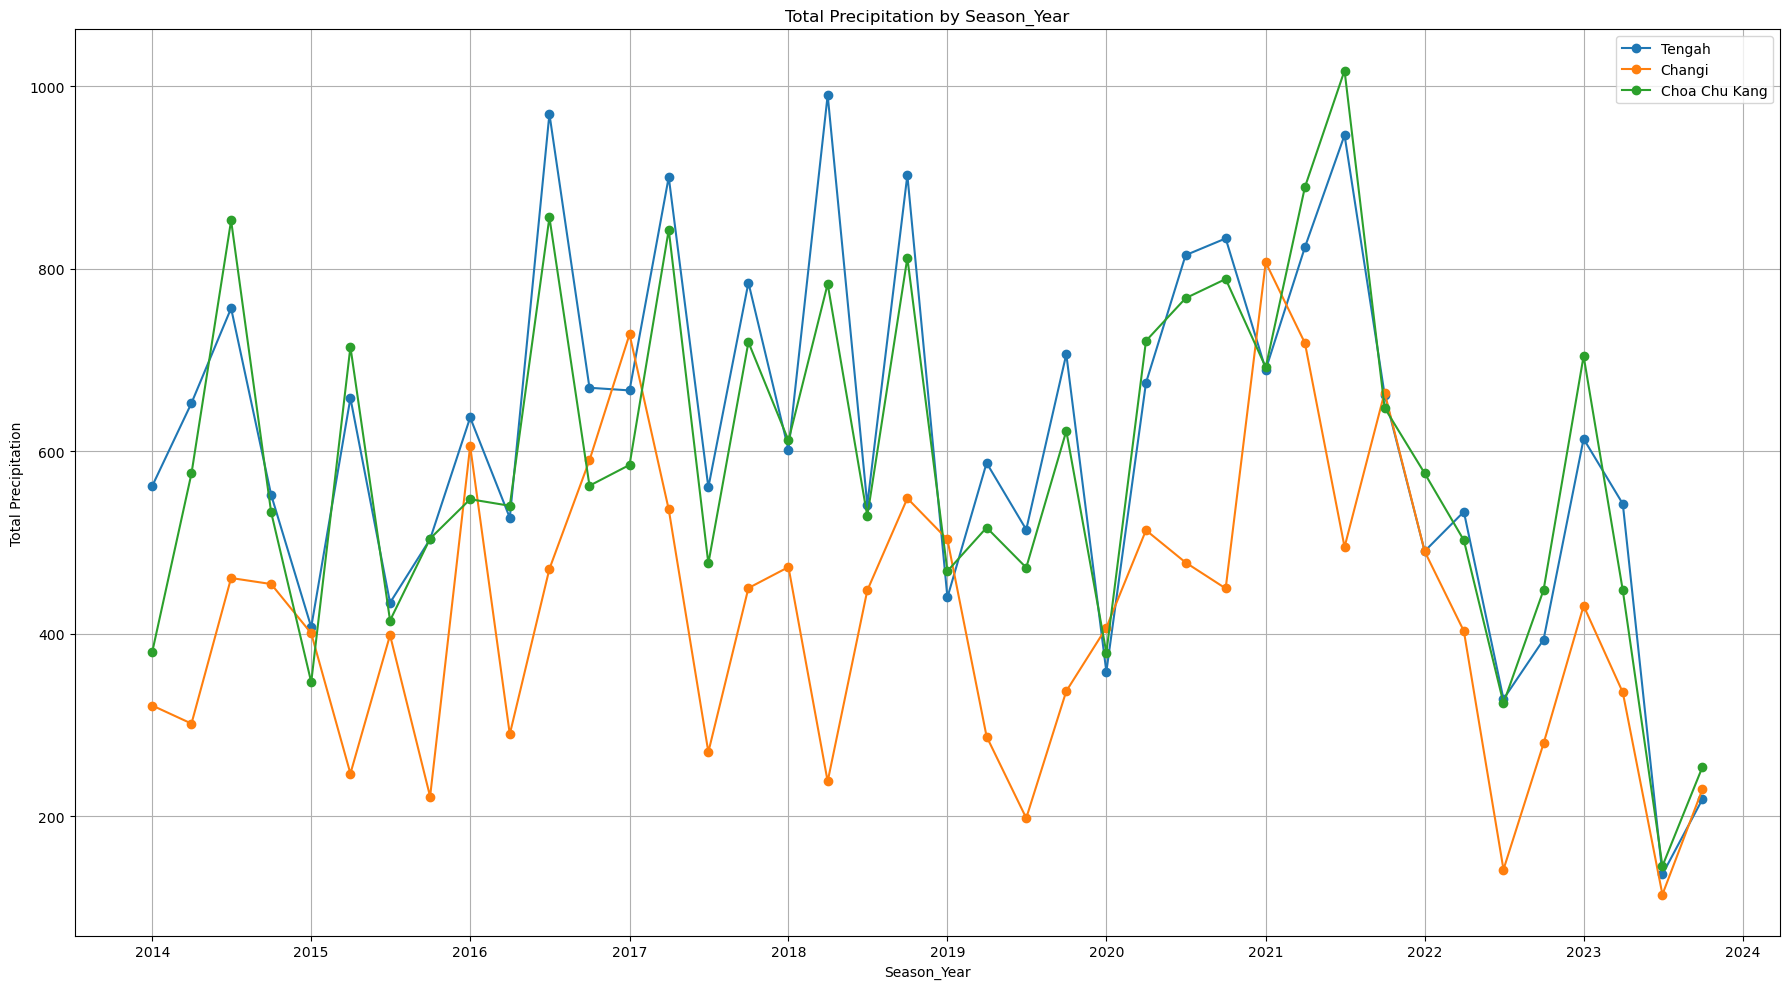

In [5]:

# Drop rows with NaN values in specific columns
NEA_filtered = filtered_dataframes["NEA"].dropna(subset=['Tengah', 'Changi', 'Choa Chu Kang'])



# Create new columns for Year and Season
NEA_filtered['Year'] = NEA_filtered['Season_Year'].str[-4:].astype(int)
NEA_filtered['Season'] = NEA_filtered['Season_Year'].str[:3]
NEA_filtered['Month'] = NEA_filtered['Season'].apply(season_to_month)

# Create a datetime column for proper sorting
NEA_filtered['Datetime'] = pd.to_datetime(NEA_filtered[['Year', 'Month']].assign(DAY=1))

# Group by Datetime and calculate the sum of precipitation for each location
NEA_tengah_sum = NEA_filtered.groupby('Datetime')['Tengah'].sum().reset_index()
NEA_changi_sum = NEA_filtered.groupby('Datetime')['Changi'].sum().reset_index()
NEA_choa_chu_kang_sum = NEA_filtered.groupby('Datetime')['Choa Chu Kang'].sum().reset_index()

# Sort the grouped dataframes by Datetime to ensure correct order
NEA_tengah_sum = NEA_tengah_sum.sort_values(by='Datetime')
NEA_changi_sum = NEA_changi_sum.sort_values(by='Datetime')
NEA_choa_chu_kang_sum = NEA_choa_chu_kang_sum.sort_values(by='Datetime')

# Plot the data
plt.figure(figsize=(18, 10))

# Plot for Tengah
plt.plot(NEA_tengah_sum['Datetime'], NEA_tengah_sum['Tengah'], label='Tengah', marker='o')

# Plot for Changi
plt.plot(NEA_changi_sum['Datetime'], NEA_changi_sum['Changi'], label='Changi', marker='o')

# Plot for Choa Chu Kang
plt.plot(NEA_choa_chu_kang_sum['Datetime'], NEA_choa_chu_kang_sum['Choa Chu Kang'], label='Choa Chu Kang', marker='o')

# Add labels and title
plt.xlabel('Season_Year')
plt.ylabel('Total Precipitation')
plt.title('Total Precipitation by Season_Year')
plt.legend()


plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


Seasonal analysis. Comparing long term performance of datasets against NEA

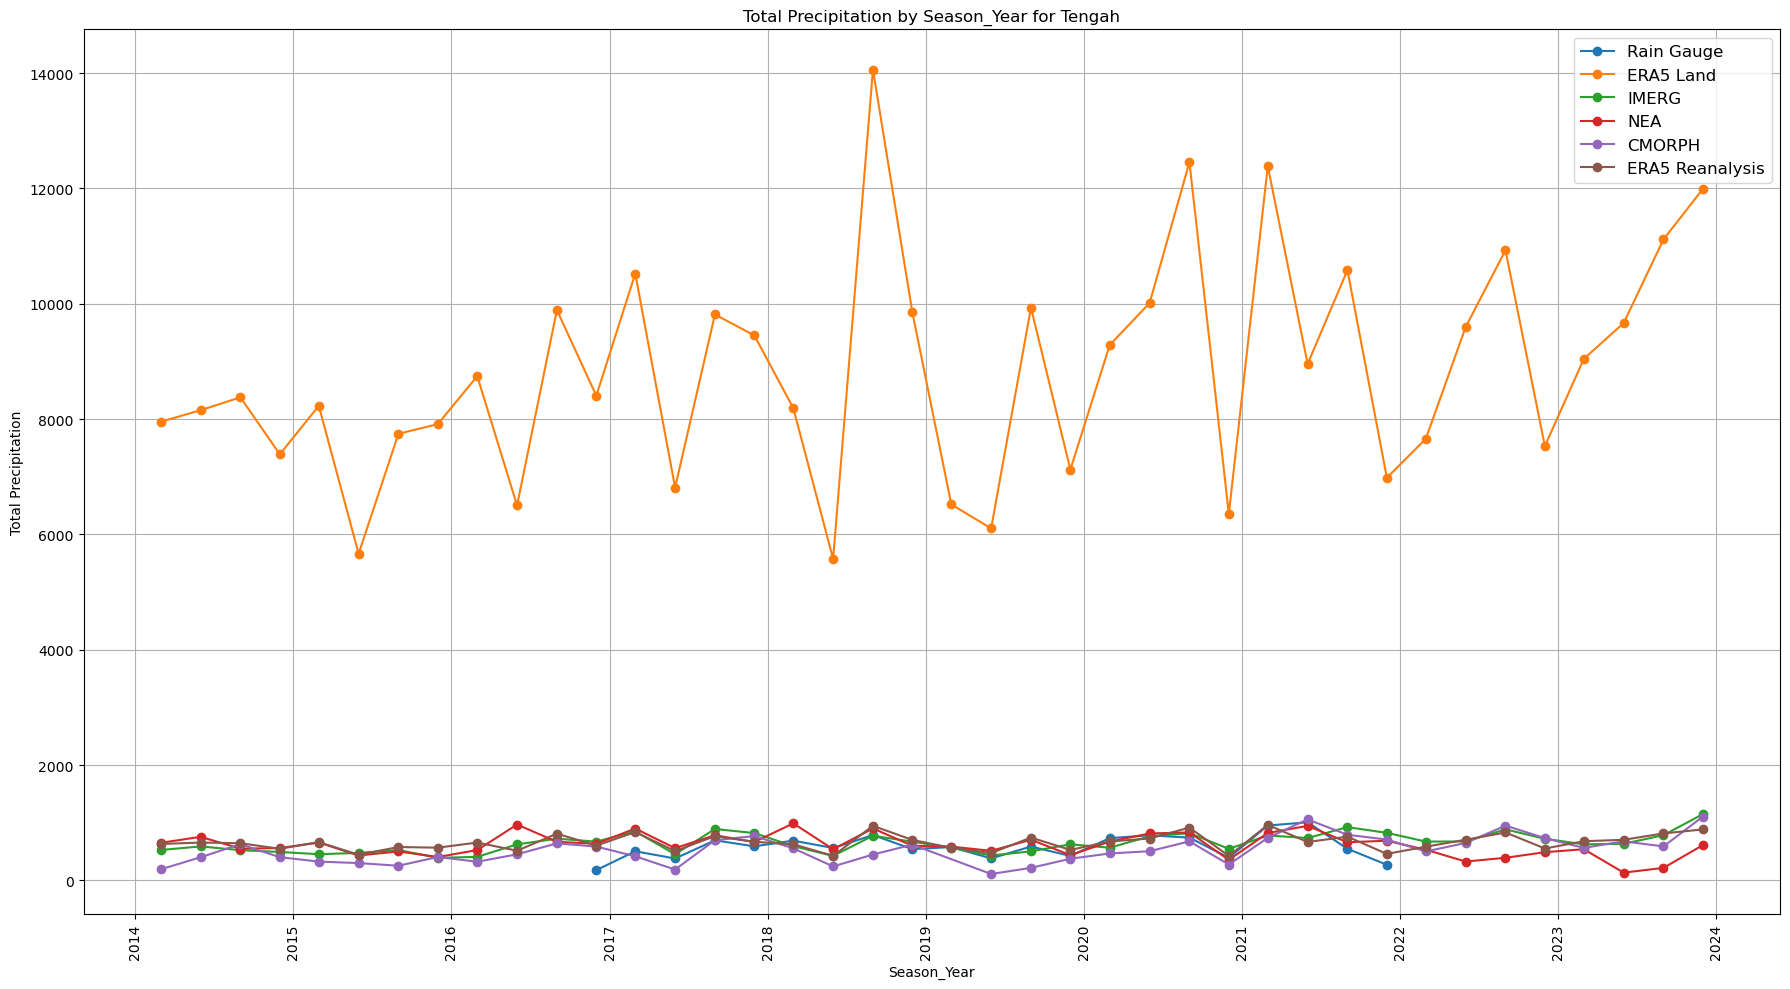

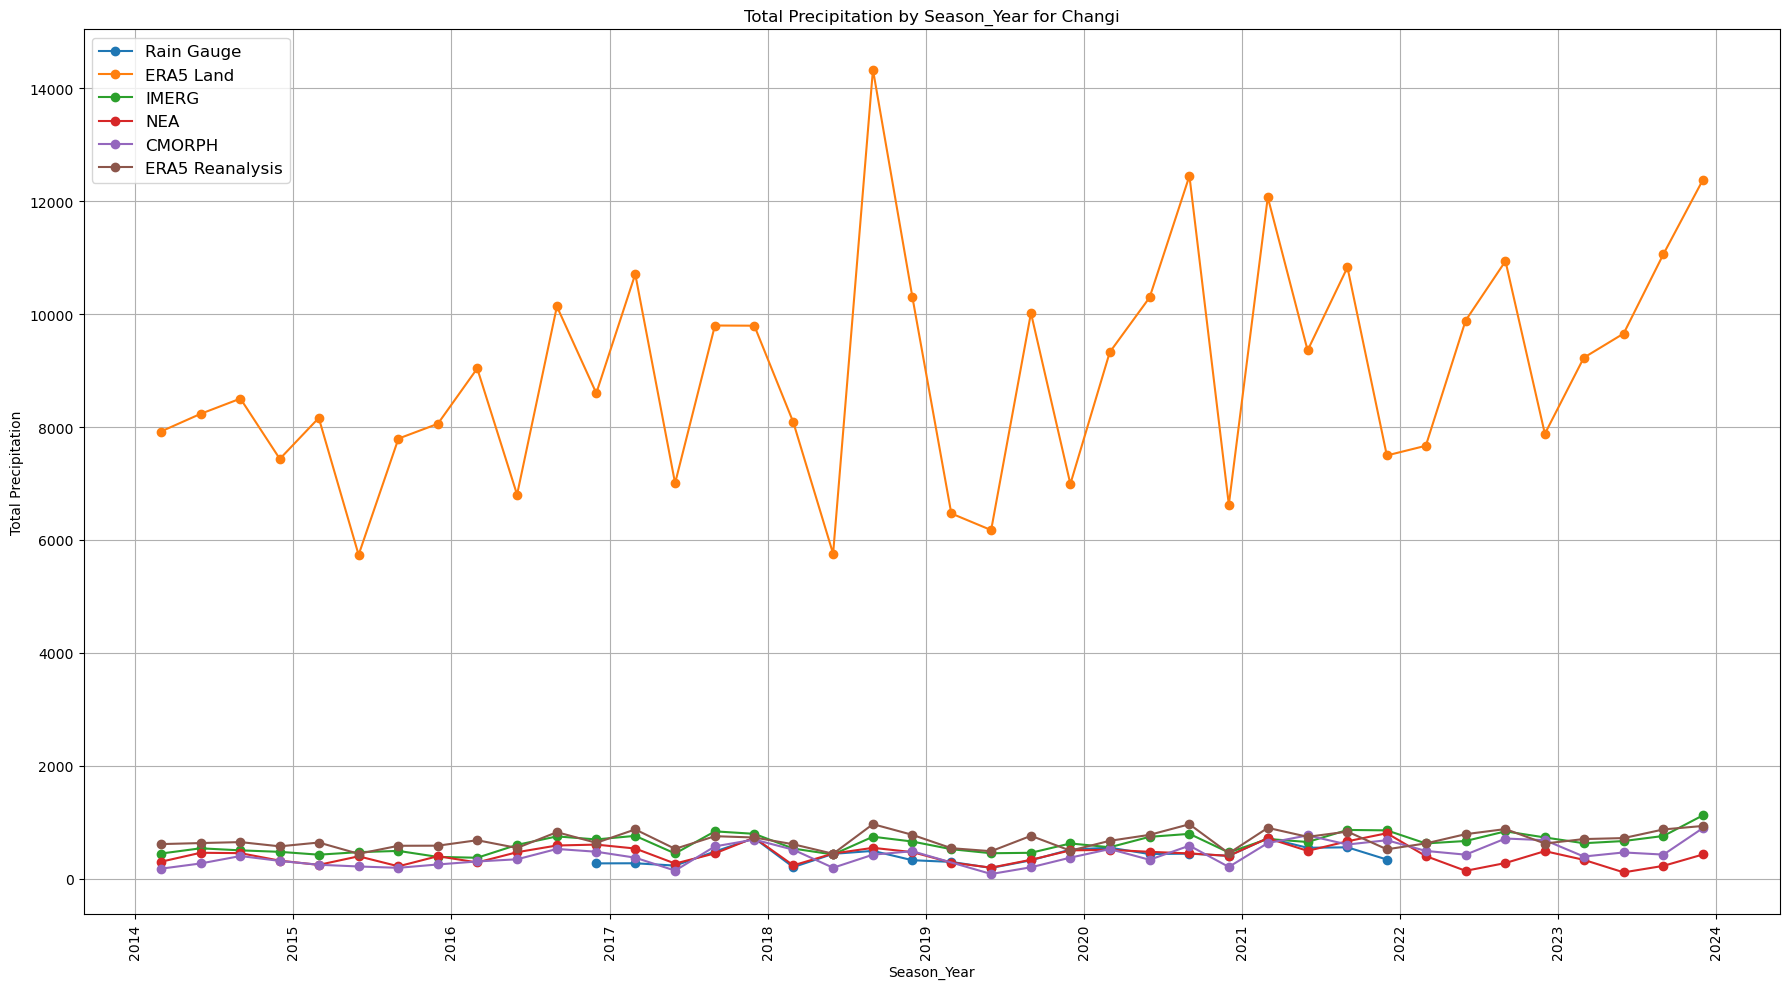

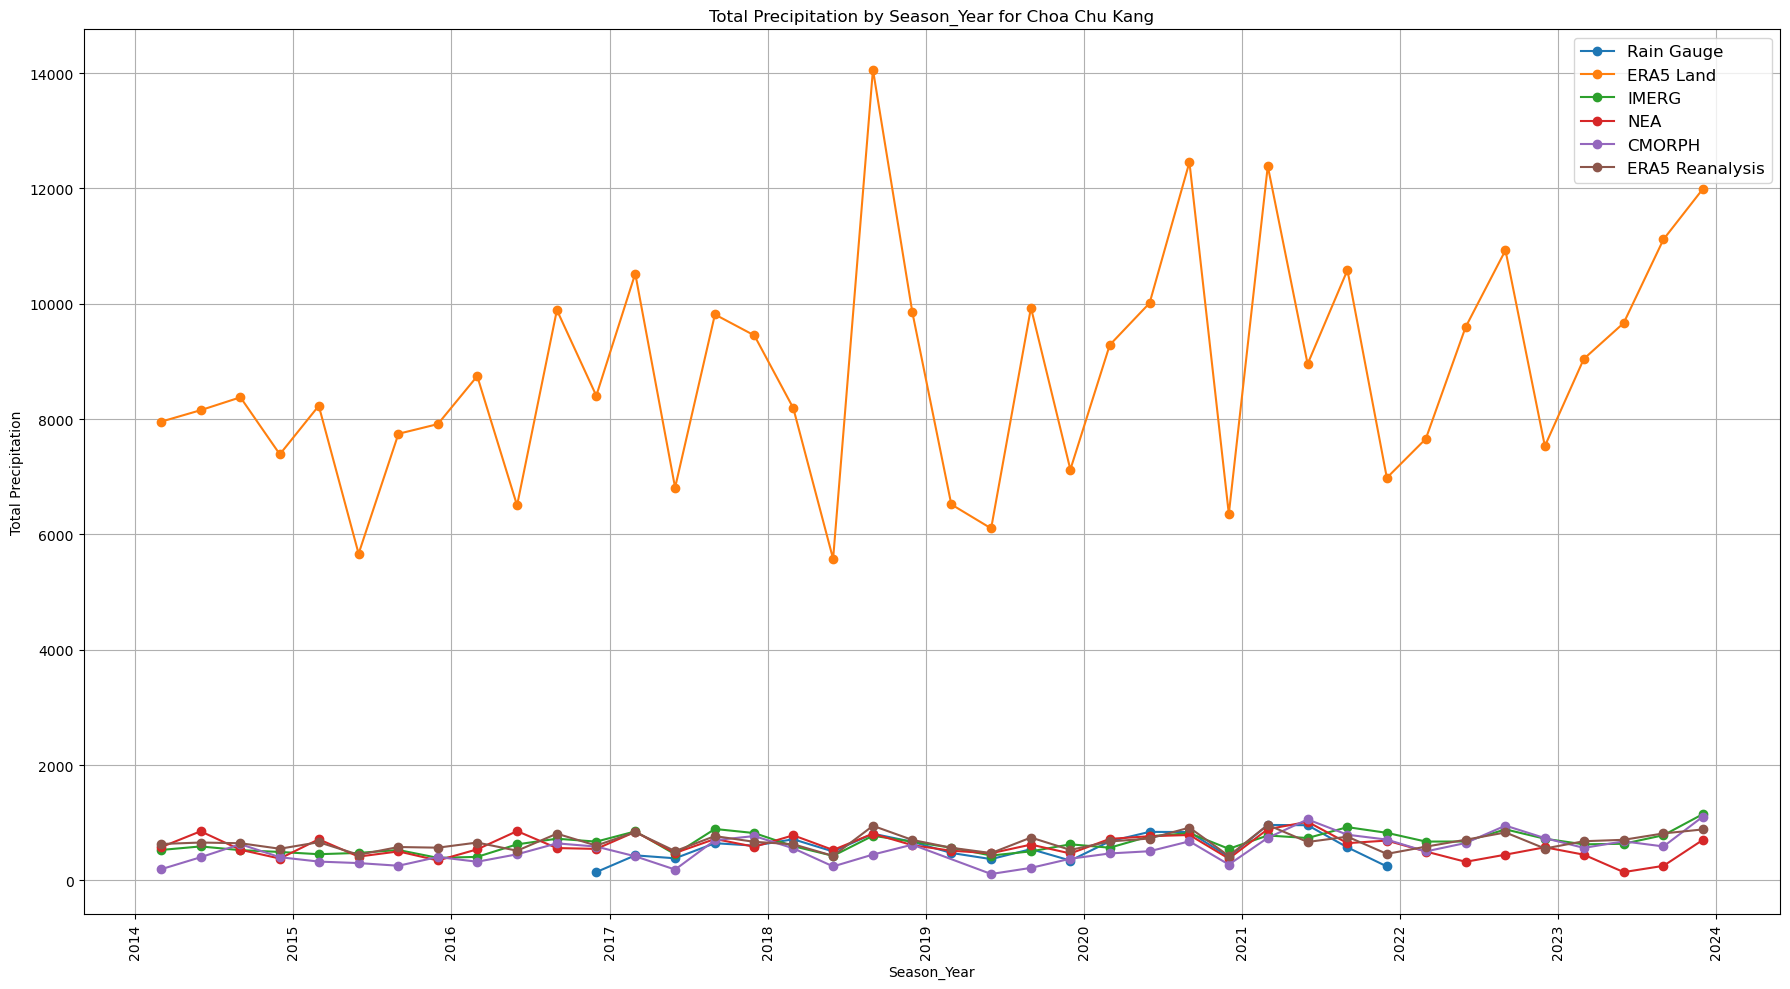

Metrics for Tengah:
           Dataset          MAE  Correlation        KGE
0       Rain Gauge   144.470003     0.662458   0.547516
1        ERA5 Land  8441.150640     0.652087 -16.117390
2            IMERG   132.309501     0.515593   0.507853
3           CMORPH   217.169752     0.531323   0.323489
4  ERA5 Reanalysis    96.862827     0.693227   0.689186

Metrics for Changi:
           Dataset          MAE  Correlation        KGE
0       Rain Gauge    82.205001     0.631813   0.604363
1        ERA5 Land  8807.518937     0.365359 -21.048812
2            IMERG   164.480491     0.732577   0.570997
3           CMORPH   131.916751     0.687117   0.595308
4  ERA5 Reanalysis   233.562473     0.316422   0.199507

Metrics for Choa Chu Kang:
           Dataset          MAE  Correlation        KGE
0       Rain Gauge   115.210002     0.737062   0.496310
1        ERA5 Land  8474.890640     0.662011 -17.026714
2            IMERG   121.445999     0.564663   0.562176
3           CMORPH   188.744251    

In [6]:

# Extract relevant columns from each dataset
rain_gauge_relevant = extract_relevant_columns(filtered_dataframes["rain_gauge"], 'Rain Gauge')
ERA5_Reanalysis_relevant = extract_relevant_columns(filtered_dataframes["ERA5_Reanalysis"], 'ERA5 Reanalysis')
ERA5_Land_relevant = extract_relevant_columns(filtered_dataframes["ERA5_Land"], 'ERA5 Land')
IMERG_relevant = extract_relevant_columns(filtered_dataframes["IMERG"], 'IMERG')
NEA_relevant = extract_relevant_columns(filtered_dataframes["NEA"], 'NEA')
CMORPH_relevant = extract_relevant_columns(filtered_dataframes["CMORPH"], 'CMORPH')

# Apply the required multipliers
ERA5_Land_relevant[['Tengah', 'Changi', 'Choa Chu Kang']] *= 1000
ERA5_Reanalysis_relevant[['Tengah', 'Changi', 'Choa Chu Kang']] *= 1000
IMERG_relevant[['Tengah', 'Changi', 'Choa Chu Kang']] /= 2
CMORPH_relevant[['Tengah', 'Changi', 'Choa Chu Kang']] /= 2

# Combine all datasets
combined_data = pd.concat([rain_gauge_relevant, ERA5_Land_relevant, IMERG_relevant, NEA_relevant, CMORPH_relevant, ERA5_Reanalysis_relevant])



rain_gauge_grouped = group_by_season_year(rain_gauge_relevant)
ERA5_Land_grouped = group_by_season_year(ERA5_Land_relevant)
IMERG_grouped = group_by_season_year(IMERG_relevant)
NEA_grouped = group_by_season_year(NEA_relevant)
CMORPH_grouped = group_by_season_year(CMORPH_relevant)
ERA5_Reanalysis_grouped = group_by_season_year(ERA5_Reanalysis_relevant)

# Function to plot data for a specific location
def plot_location_data(location):
    plt.figure(figsize=(18, 10))
    
    # Plot for each dataset
    for data, name in zip([rain_gauge_grouped, ERA5_Land_grouped, IMERG_grouped, NEA_grouped, CMORPH_grouped, ERA5_Reanalysis_grouped], 
                          ['Rain Gauge', 'ERA5 Land', 'IMERG', 'NEA', 'CMORPH', 'ERA5 Reanalysis']):
        plt.plot(data['Datetime'], data[location], label=name, marker='o')
    
    # Add labels and title
    plt.xlabel('Season_Year')
    plt.ylabel('Total Precipitation')
    plt.title(f'Total Precipitation by Season_Year for {location}')
    plt.legend(fontsize='large')
    
    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=90)
    
    plt.grid(True)
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Plot data for each location
for location in ['Tengah', 'Changi', 'Choa Chu Kang']:
    plot_location_data(location)


# Calculate and print metrics for each location
locations = ['Tengah', 'Changi', 'Choa Chu Kang']
for location in locations:
    metrics = calculate_metrics(location)
    print(f'Metrics for {location}:')
    print(metrics)
    print()


Visualising CDF of rain rates for each dataset for each season

Rain Gauge - DJF Probability of 20mm/h rain: 0.0030
Rain Gauge - MAM Probability of 20mm/h rain: 0.0053
Rain Gauge - JJA Probability of 20mm/h rain: 0.0046
Rain Gauge - SON Probability of 20mm/h rain: 0.0049
ERA5 Land - DJF Probability of 20mm/h rain: 0.0302
ERA5 Land - MAM Probability of 20mm/h rain: 0.0181
ERA5 Land - JJA Probability of 20mm/h rain: 0.0098
ERA5 Land - SON Probability of 20mm/h rain: 0.0303
IMERG - DJF Probability of 20mm/h rain: 0.0000
IMERG - MAM Probability of 20mm/h rain: 0.0001
IMERG - JJA Probability of 20mm/h rain: 0.0002
IMERG - SON Probability of 20mm/h rain: 0.0001
CMORPH - DJF Probability of 20mm/h rain: 0.0014
CMORPH - MAM Probability of 20mm/h rain: 0.0005
CMORPH - JJA Probability of 20mm/h rain: 0.0007
CMORPH - SON Probability of 20mm/h rain: 0.0009
ERA5 Reanalysis - DJF Probability of 20mm/h rain: 0.0000
ERA5 Reanalysis - MAM Probability of 20mm/h rain: 0.0000
ERA5 Reanalysis - JJA Probability of 20mm/h rain: 0.0000
ERA5 Reanalysis - SON Probability of 

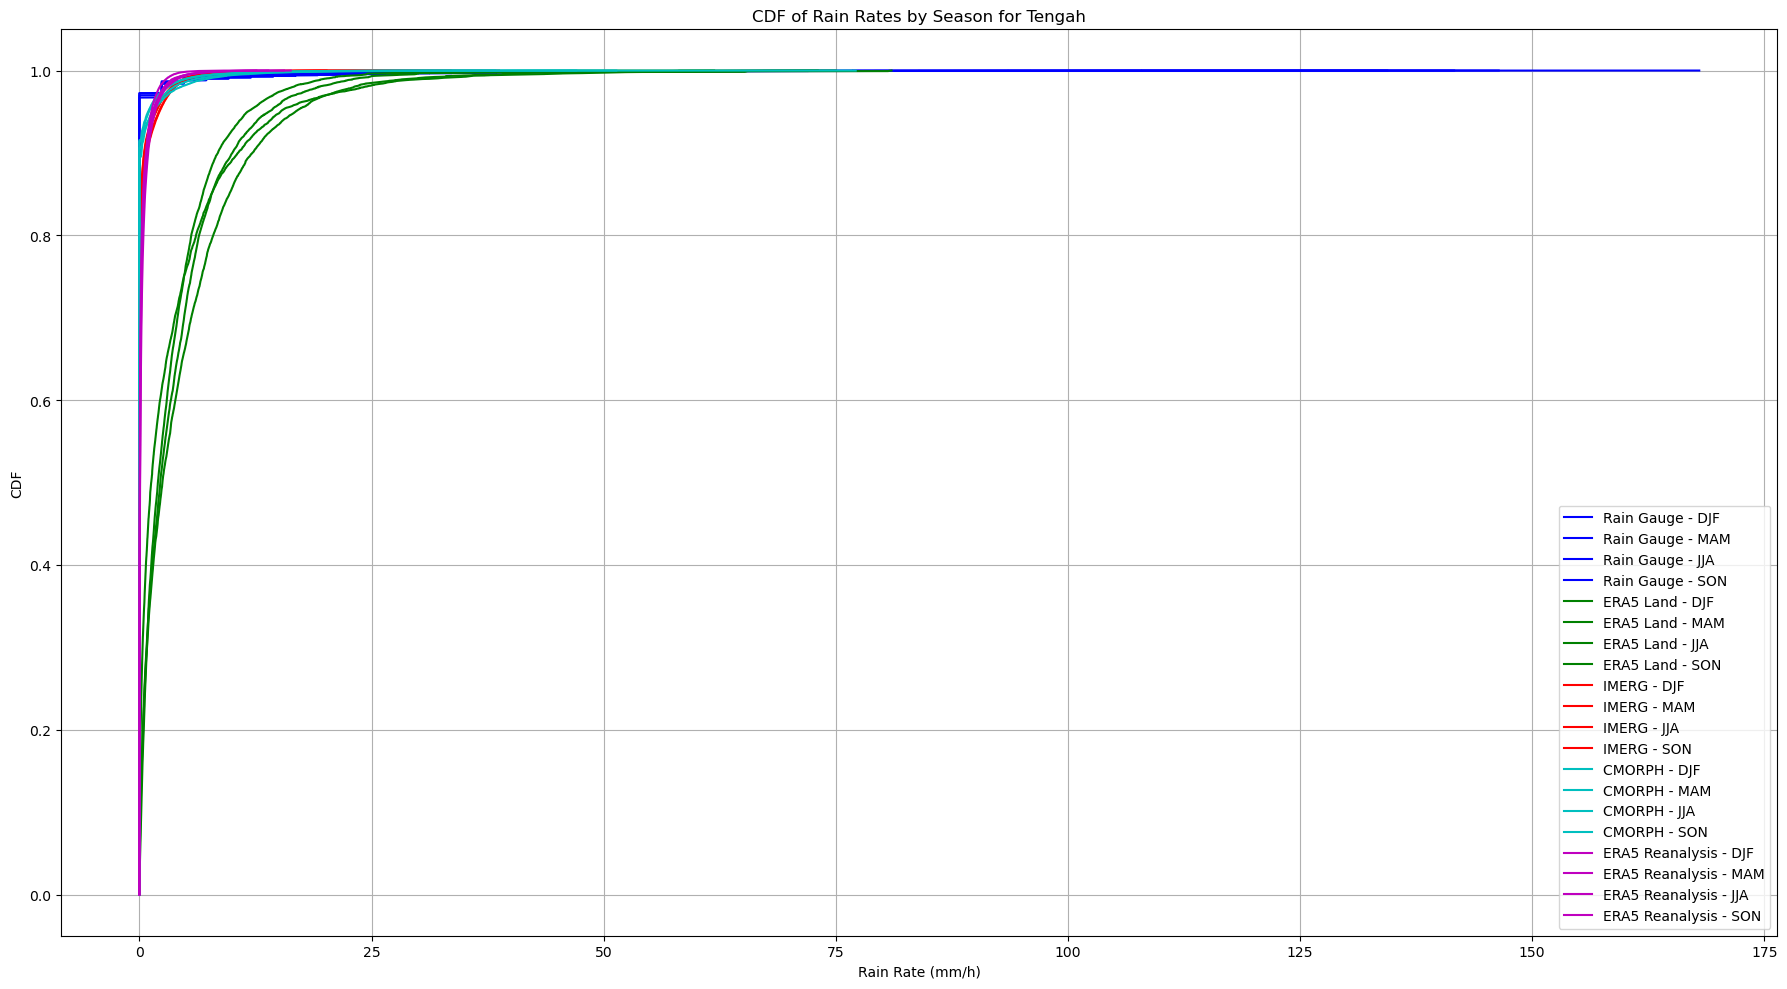

Rain Gauge - DJF Probability of 20mm/h rain: 0.0033
Rain Gauge - MAM Probability of 20mm/h rain: 0.0031
Rain Gauge - JJA Probability of 20mm/h rain: 0.0026
Rain Gauge - SON Probability of 20mm/h rain: 0.0029
ERA5 Land - DJF Probability of 20mm/h rain: 0.0316
ERA5 Land - MAM Probability of 20mm/h rain: 0.0171
ERA5 Land - JJA Probability of 20mm/h rain: 0.0105
ERA5 Land - SON Probability of 20mm/h rain: 0.0307
IMERG - DJF Probability of 20mm/h rain: 0.0001
IMERG - MAM Probability of 20mm/h rain: 0.0001
IMERG - JJA Probability of 20mm/h rain: 0.0002
IMERG - SON Probability of 20mm/h rain: 0.0002
CMORPH - DJF Probability of 20mm/h rain: 0.0006
CMORPH - MAM Probability of 20mm/h rain: 0.0002
CMORPH - JJA Probability of 20mm/h rain: 0.0001
CMORPH - SON Probability of 20mm/h rain: 0.0003
ERA5 Reanalysis - DJF Probability of 20mm/h rain: 0.0000
ERA5 Reanalysis - MAM Probability of 20mm/h rain: 0.0000
ERA5 Reanalysis - JJA Probability of 20mm/h rain: 0.0000
ERA5 Reanalysis - SON Probability of 

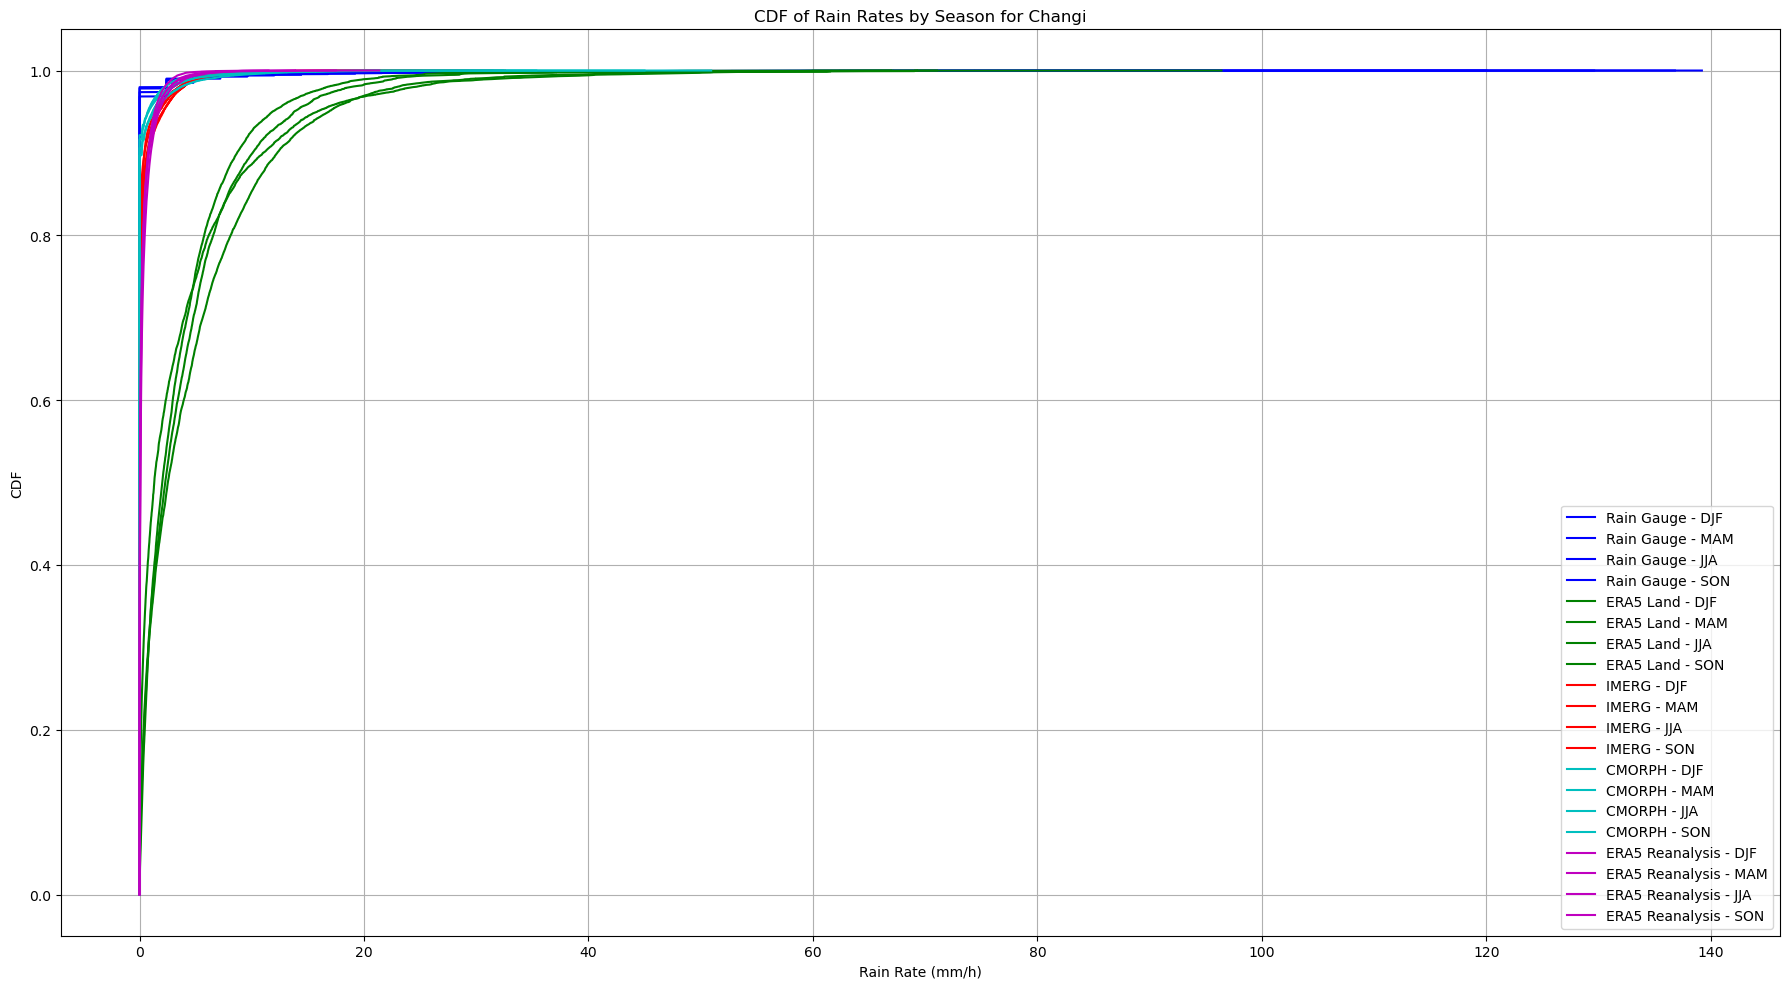

Rain Gauge - DJF Probability of 20mm/h rain: 0.0028
Rain Gauge - MAM Probability of 20mm/h rain: 0.0049
Rain Gauge - JJA Probability of 20mm/h rain: 0.0044
Rain Gauge - SON Probability of 20mm/h rain: 0.0048
ERA5 Land - DJF Probability of 20mm/h rain: 0.0302
ERA5 Land - MAM Probability of 20mm/h rain: 0.0181
ERA5 Land - JJA Probability of 20mm/h rain: 0.0098
ERA5 Land - SON Probability of 20mm/h rain: 0.0303
IMERG - DJF Probability of 20mm/h rain: 0.0000
IMERG - MAM Probability of 20mm/h rain: 0.0001
IMERG - JJA Probability of 20mm/h rain: 0.0002
IMERG - SON Probability of 20mm/h rain: 0.0001
CMORPH - DJF Probability of 20mm/h rain: 0.0014
CMORPH - MAM Probability of 20mm/h rain: 0.0005
CMORPH - JJA Probability of 20mm/h rain: 0.0007
CMORPH - SON Probability of 20mm/h rain: 0.0009
ERA5 Reanalysis - DJF Probability of 20mm/h rain: 0.0000
ERA5 Reanalysis - MAM Probability of 20mm/h rain: 0.0000
ERA5 Reanalysis - JJA Probability of 20mm/h rain: 0.0000
ERA5 Reanalysis - SON Probability of 

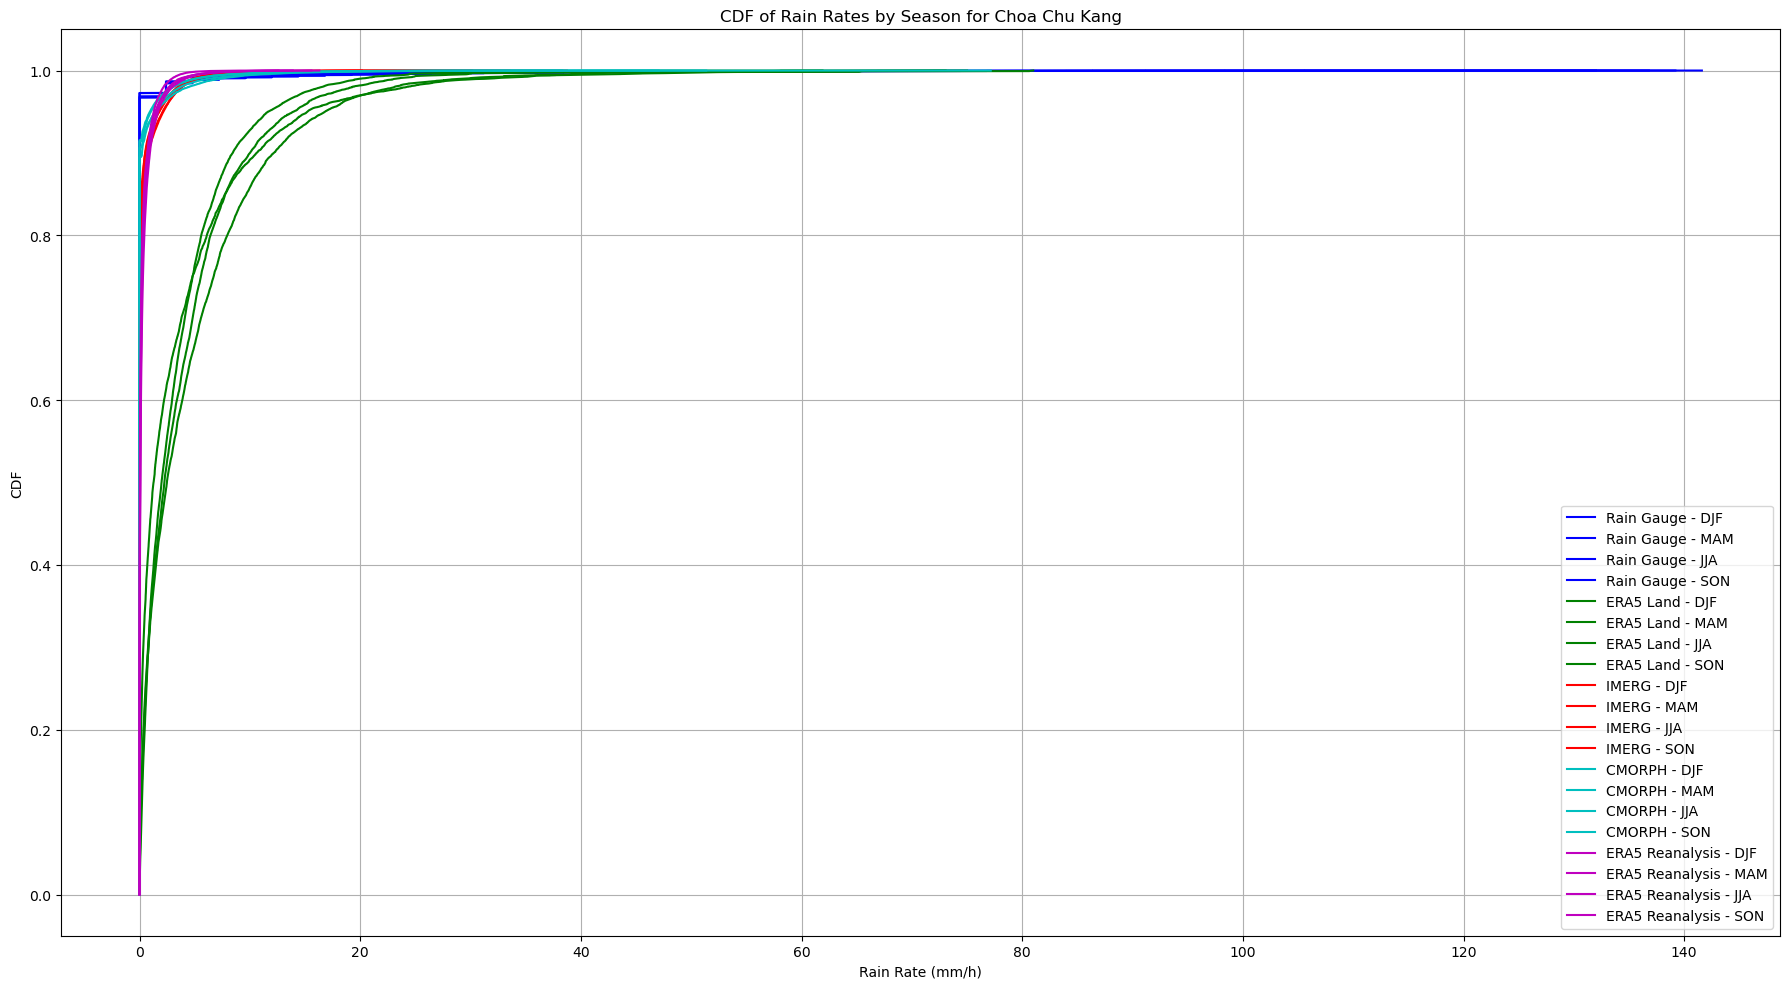

In [7]:

# Extract and process relevant columns from each dataset
rain_gauge_data = process_dataset(filtered_dataframes["rain_gauge"], 'Rain Gauge')
ERA5_Land_data = process_dataset(filtered_dataframes["ERA5_Land"], 'ERA5 Land')
IMERG_data = process_dataset(filtered_dataframes["IMERG"], 'IMERG')
CMORPH_data = process_dataset(filtered_dataframes["CMORPH"], 'CMORPH')
ERA5_Reanalysis_data = process_dataset(filtered_dataframes["ERA5_Reanalysis"], 'ERA5 Reanalysis')

# Apply the required multipliers
ERA5_Land_data[['Tengah', 'Changi', 'Choa Chu Kang']] *= 1000
ERA5_Reanalysis_data[['Tengah', 'Changi', 'Choa Chu Kang']] *= 1000
rain_gauge_data[['Tengah', 'Changi', 'Choa Chu Kang']] *= 12

# Combine all datasets except NEA
combined_datasets = pd.concat([rain_gauge_data, ERA5_Land_data, IMERG_data, CMORPH_data, ERA5_Reanalysis_data])

# Function to calculate CDF and probability for 20mm/h rain
def calculate_cdf_and_probability(data, location):
    seasons = ['DJF', 'MAM', 'JJA', 'SON']
    results = {}

    for season in seasons:
        season_data = data[data['Season'] == season][location]
        sorted_data = np.sort(season_data)
        cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
        
        # Handle the case where searchsorted returns an out-of-bounds index
        index_20mm = np.searchsorted(sorted_data, 20)
        probability = 0.0 if index_20mm >= len(sorted_data) else 1 - cdf[index_20mm]
        
        results[season] = {'CDF': cdf, 'Sorted_Data': sorted_data, 'Probability': probability}
    
    return results

# Function to plot CDF for each dataset and season
def plot_cdf(location):
    plt.figure(figsize=(18, 10))
    
    datasets = ['Rain Gauge', 'ERA5 Land', 'IMERG', 'CMORPH', 'ERA5 Reanalysis']
    colors = ['b', 'g', 'r', 'c', 'm']
    
    for dataset, color in zip(datasets, colors):
        data = combined_datasets[combined_datasets['Dataset'] == dataset]
        cdf_results = calculate_cdf_and_probability(data, location)
        
        for season, result in cdf_results.items():
            plt.plot(result['Sorted_Data'], result['CDF'], label=f'{dataset} - {season}', color=color)
            print(f'{dataset} - {season} Probability of 20mm/h rain: {result["Probability"]:.4f}')
    
    # Add labels and title
    plt.xlabel('Rain Rate (mm/h)')
    plt.ylabel('CDF')
    plt.title(f'CDF of Rain Rates by Season for {location}')
    plt.legend()
    
    plt.grid(True)
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Plot CDF for each location
for location in ['Tengah', 'Changi', 'Choa Chu Kang']:
    plot_cdf(location)

Descriptive statistics using L-moments and KS test used to evaluate how close are the CDF distributions for each dataset against rain gauge data from Data.gov

Rain Gauge - DJF GEV Params: shape=-0.9881, loc=0.0061, scale=0.0032
ERA5 Land - DJF GEV Params: shape=-1.6277, loc=3.0602, scale=-0.3037
IMERG - DJF GEV Params: shape=-0.9596, loc=0.0564, scale=0.0107
CMORPH - DJF GEV Params: shape=-0.9685, loc=0.0175, scale=0.0075
ERA5 Reanalysis - DJF GEV Params: shape=-1.0947, loc=0.1147, scale=-0.0160


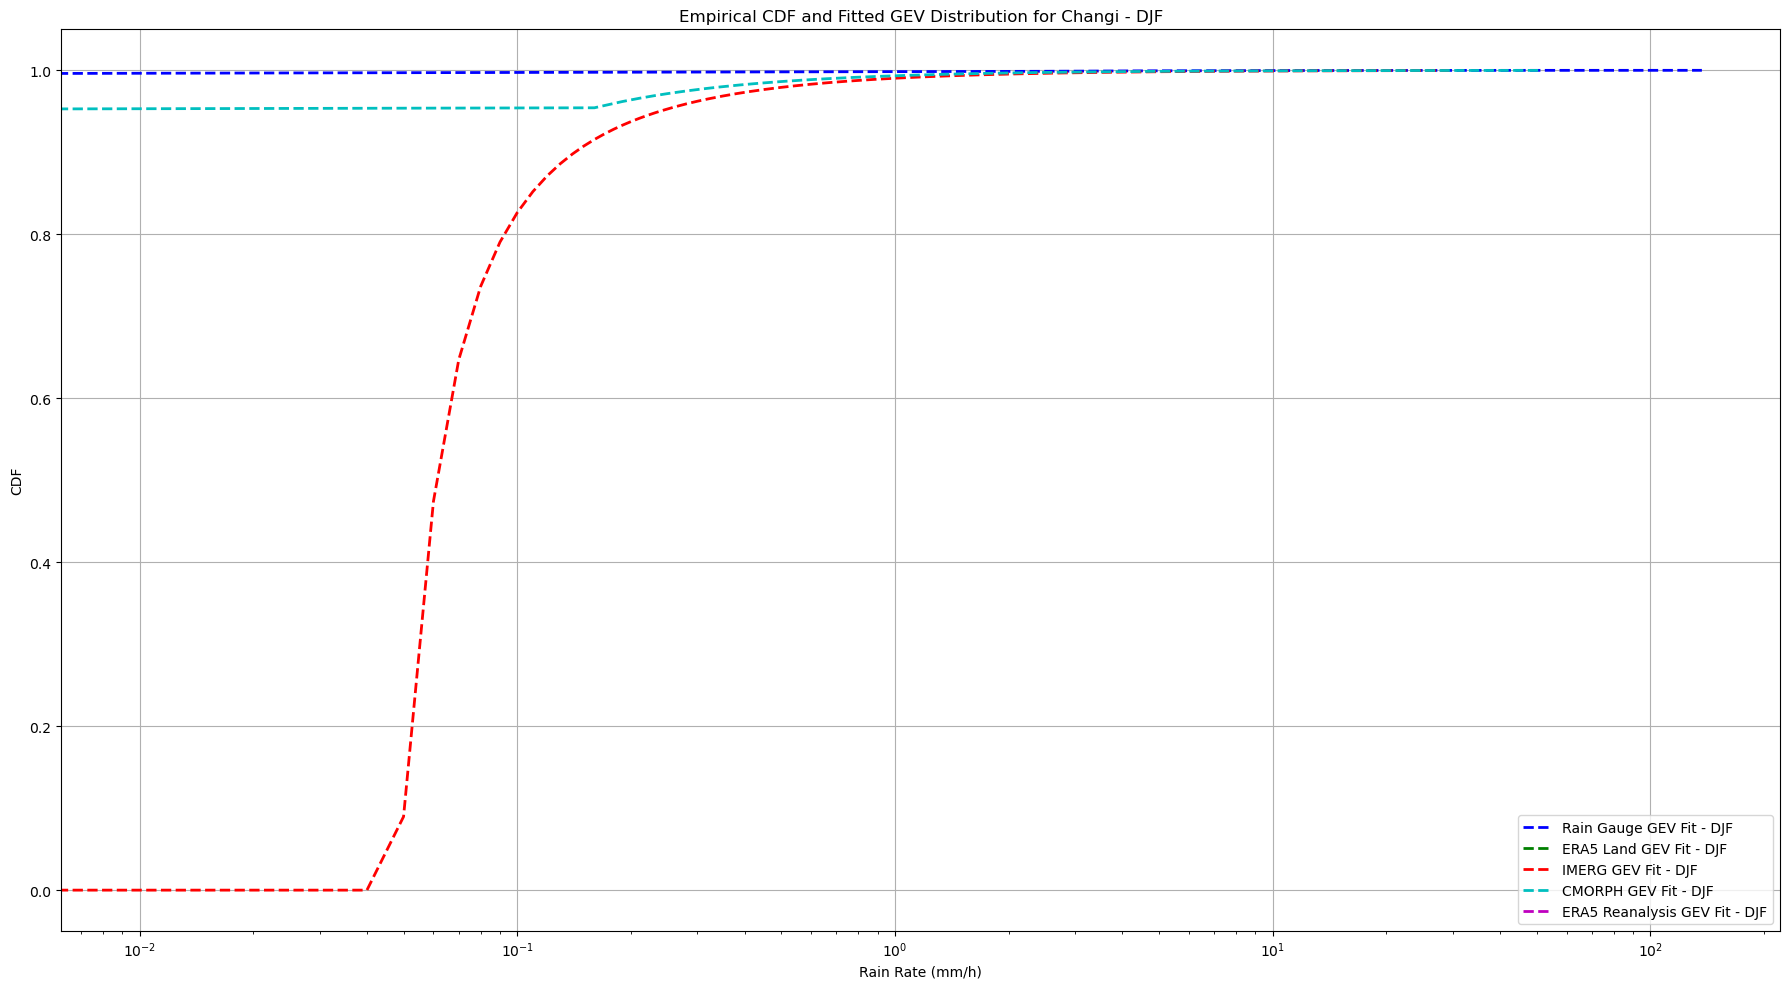

Rain Gauge - MAM GEV Params: shape=-0.9926, loc=0.0029, scale=0.0016
ERA5 Land - MAM GEV Params: shape=-2.7569, loc=3.9335, scale=0.1259
IMERG - MAM GEV Params: shape=-0.9581, loc=0.0326, scale=0.0095
CMORPH - MAM GEV Params: shape=-0.9727, loc=0.0107, scale=0.0048
ERA5 Reanalysis - MAM GEV Params: shape=-1.2144, loc=0.1539, scale=-0.0294


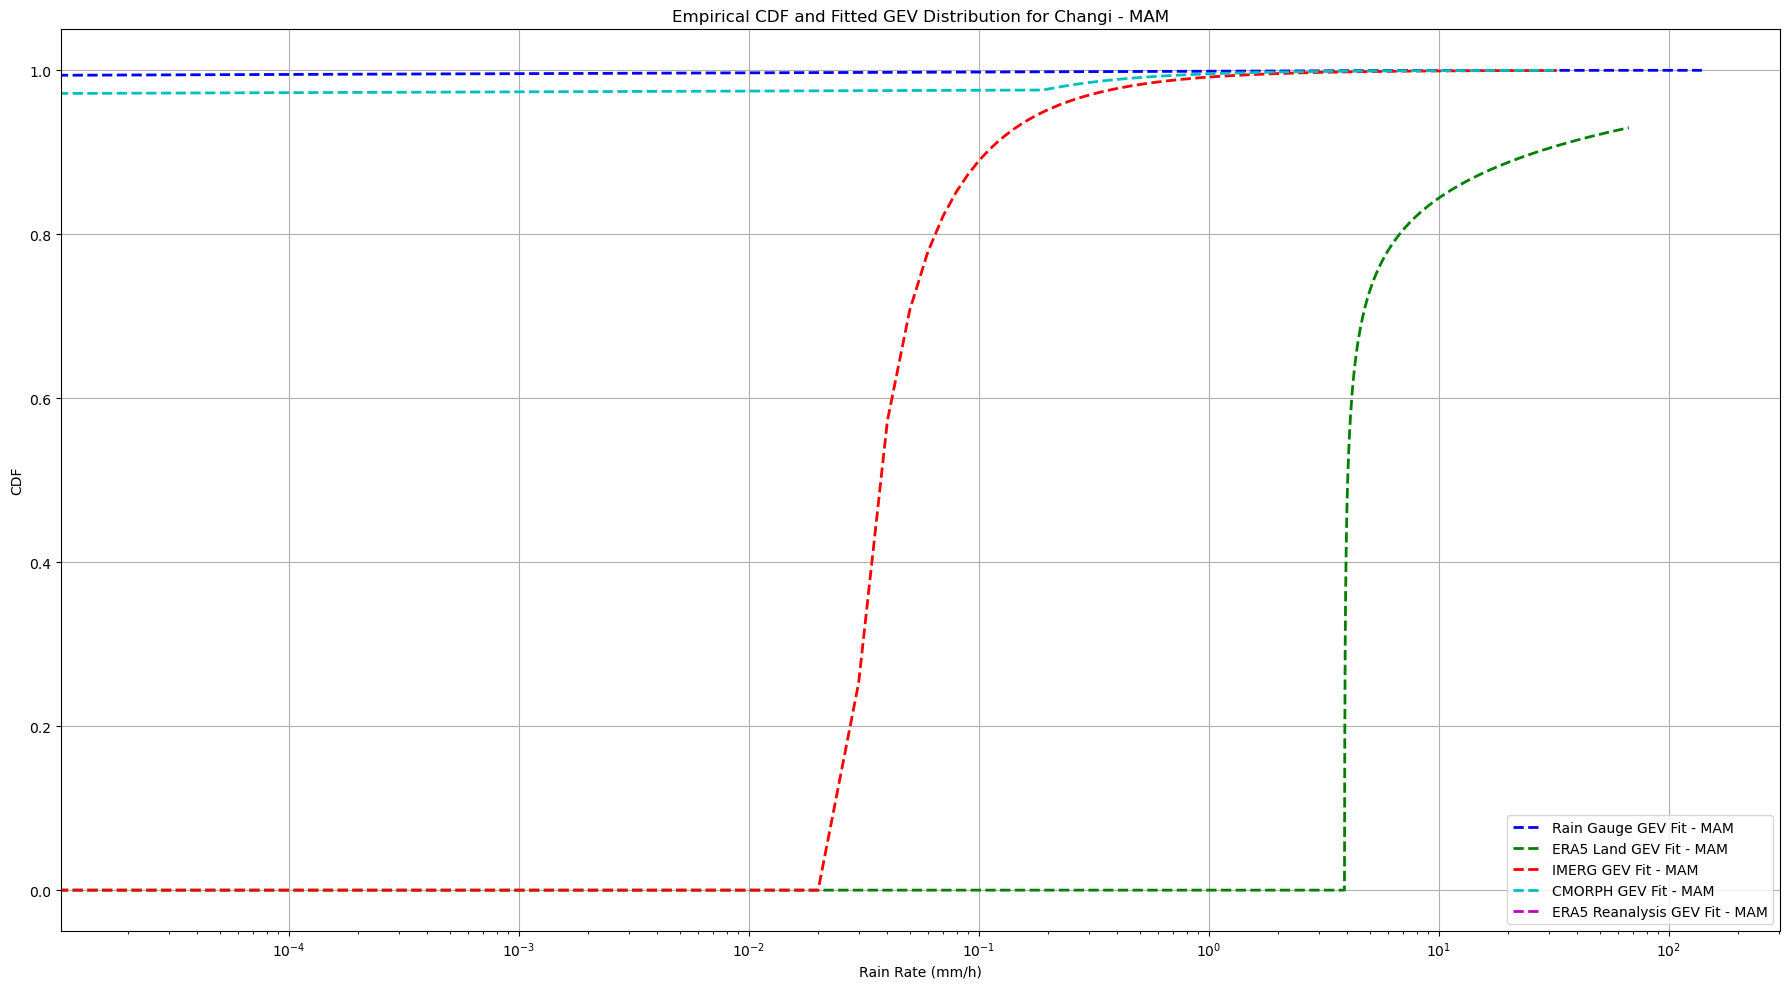

Rain Gauge - JJA GEV Params: shape=-0.9916, loc=0.0029, scale=0.0016
ERA5 Land - JJA GEV Params: shape=-3.1417, loc=3.4808, scale=-0.0697
IMERG - JJA GEV Params: shape=-0.9557, loc=0.0316, scale=0.0103
CMORPH - JJA GEV Params: shape=-0.9705, loc=0.0097, scale=0.0043
ERA5 Reanalysis - JJA GEV Params: shape=-1.2634, loc=0.1496, scale=-0.0282


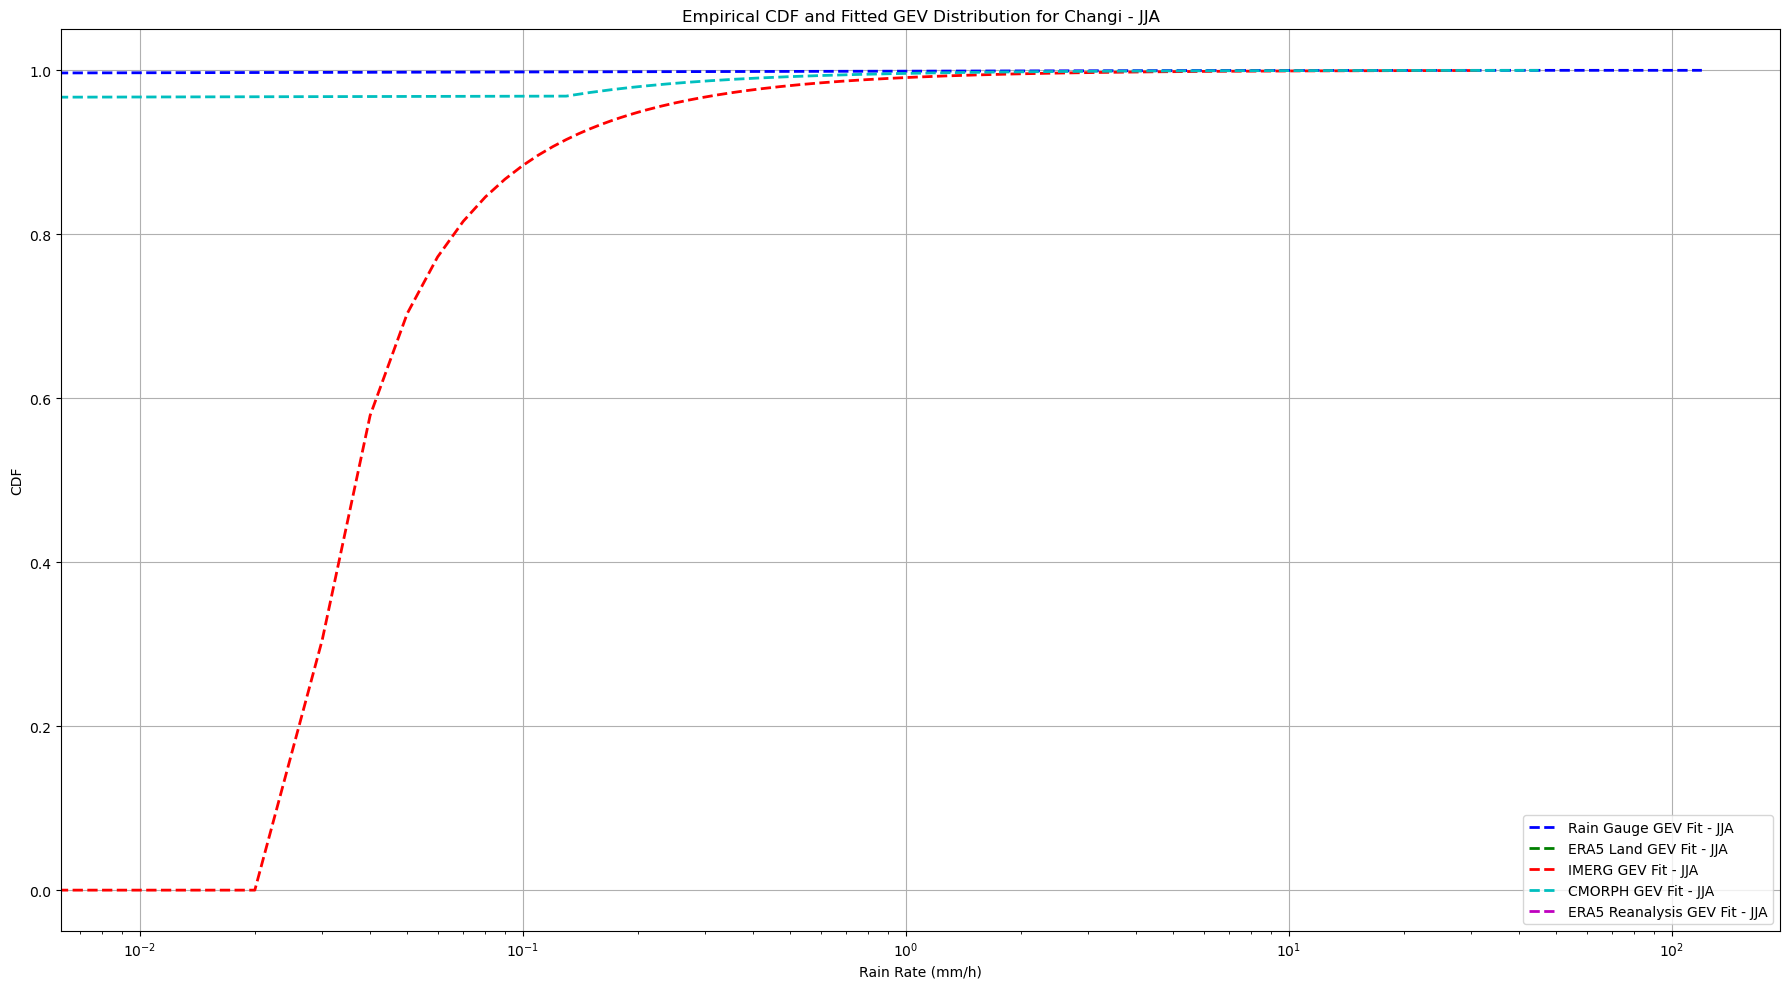

Rain Gauge - SON GEV Params: shape=-0.9903, loc=0.0042, scale=0.0022
ERA5 Land - SON GEV Params: shape=-2.4860, loc=4.7157, scale=0.2353
IMERG - SON GEV Params: shape=-0.9588, loc=0.0603, scale=0.0111
CMORPH - SON GEV Params: shape=-0.9666, loc=0.0163, scale=0.0067
ERA5 Reanalysis - SON GEV Params: shape=-1.2373, loc=0.1935, scale=-0.0360


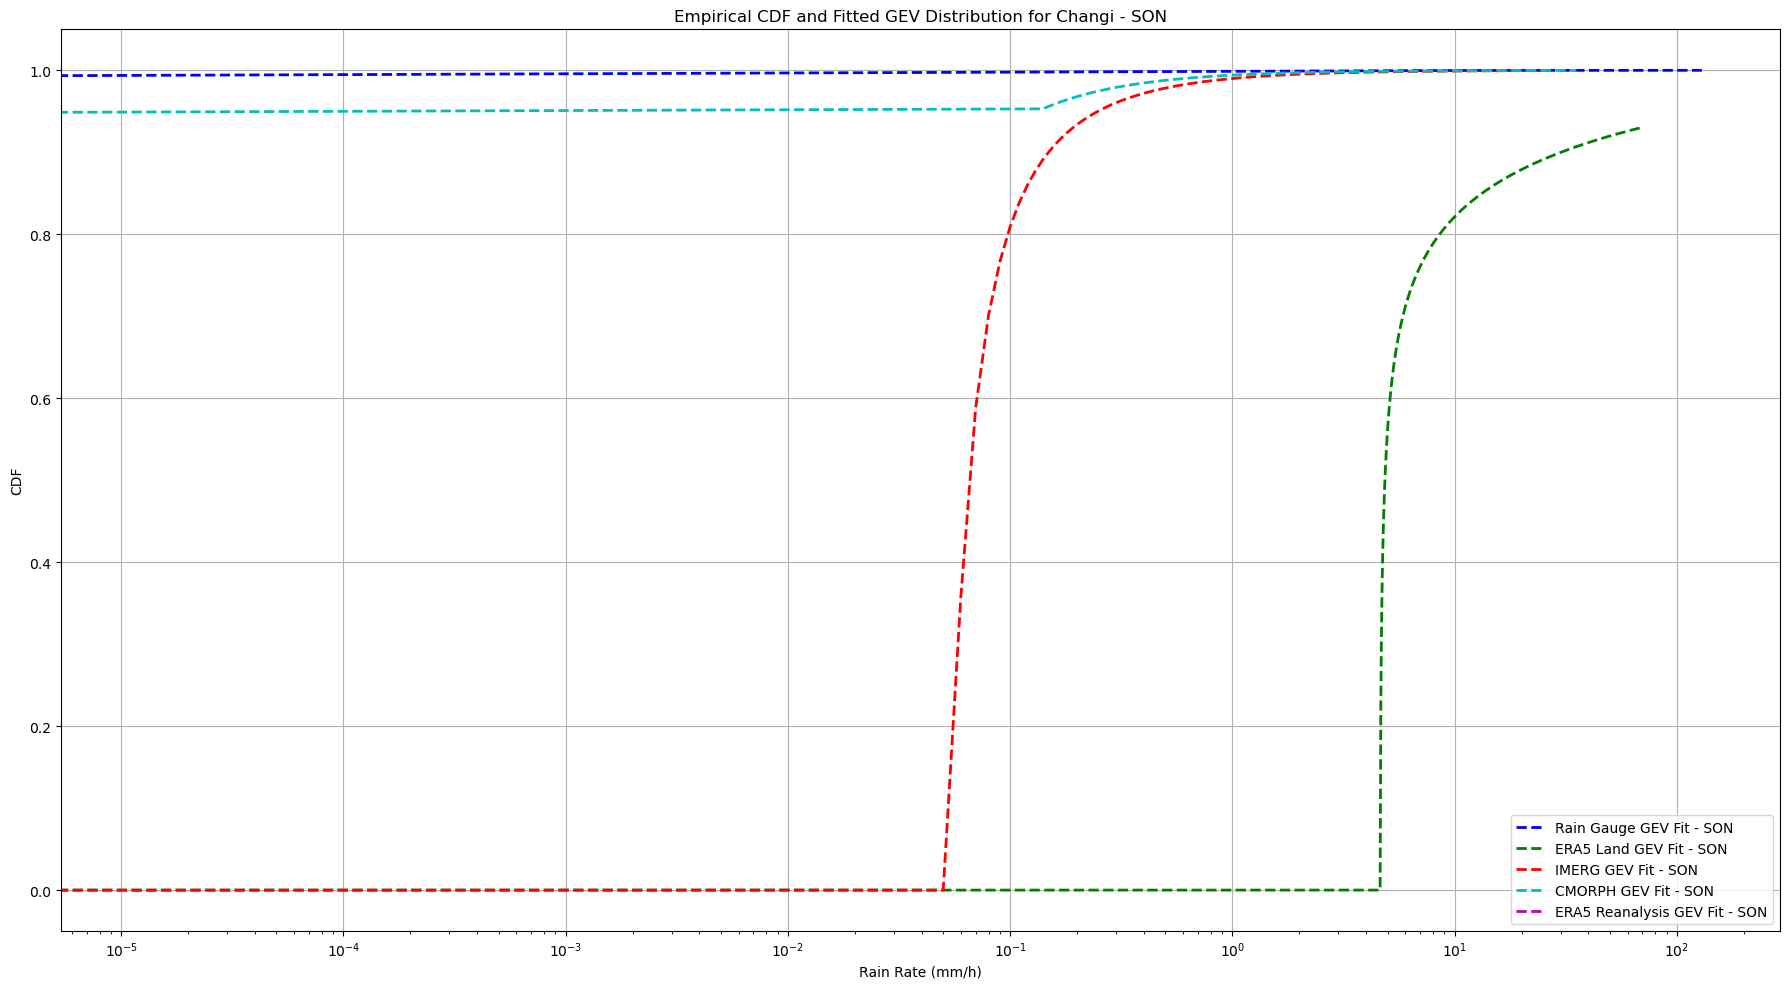

ERA5 Land - DJF KS Statistic: 0.9416, P-Value: 0.0000
IMERG - DJF KS Statistic: 0.2651, P-Value: 0.0000
CMORPH - DJF KS Statistic: 0.0626, P-Value: 0.0000
ERA5 Reanalysis - DJF KS Statistic: 0.7970, P-Value: 0.0000
ERA5 Land - MAM KS Statistic: 0.9655, P-Value: 0.0000
IMERG - MAM KS Statistic: 0.1811, P-Value: 0.0000
CMORPH - MAM KS Statistic: 0.0582, P-Value: 0.0000
ERA5 Reanalysis - MAM KS Statistic: 0.8654, P-Value: 0.0000
ERA5 Land - JJA KS Statistic: 0.9759, P-Value: 0.0000
IMERG - JJA KS Statistic: 0.1760, P-Value: 0.0000
CMORPH - JJA KS Statistic: 0.0618, P-Value: 0.0000
ERA5 Reanalysis - JJA KS Statistic: 0.8744, P-Value: 0.0000
ERA5 Land - SON KS Statistic: 0.9675, P-Value: 0.0000
IMERG - SON KS Statistic: 0.2654, P-Value: 0.0000
CMORPH - SON KS Statistic: 0.0768, P-Value: 0.0000
ERA5 Reanalysis - SON KS Statistic: 0.8486, P-Value: 0.0000


In [8]:


# Extract and process relevant columns from each dataset
rain_gauge_data = process_dataset(filtered_dataframes["rain_gauge"], 'Rain Gauge')
ERA5_Land_data = process_dataset(filtered_dataframes["ERA5_Land"], 'ERA5 Land')
IMERG_data = process_dataset(filtered_dataframes["IMERG"], 'IMERG')
CMORPH_data = process_dataset(filtered_dataframes["CMORPH"], 'CMORPH')
ERA5_Reanalysis_data = process_dataset(filtered_dataframes["ERA5_Reanalysis"], 'ERA5 Reanalysis')

# Apply the required multipliers
ERA5_Land_data[['Tengah', 'Changi', 'Choa Chu Kang']] *= 1000
ERA5_Reanalysis_data[['Tengah', 'Changi', 'Choa Chu Kang']] *= 1000
rain_gauge_data[['Tengah', 'Changi', 'Choa Chu Kang']] *= 12

# Combine all datasets except NEA
combined_data = pd.concat([rain_gauge_data, ERA5_Land_data, IMERG_data, CMORPH_data, ERA5_Reanalysis_data])

# Function to calculate L-moments
def calculate_l_moments(data):
    n = len(data)
    if n == 0:
        return [np.nan, np.nan, np.nan]
    
    b0 = np.mean(data)
    data_sorted = np.sort(data)
    
    b1 = np.mean([(i + 1 - (n - i)) * data_sorted[i] for i in range(n)]) / n
    l1 = b0
    l2 = 2 * b1 - b0
    
    if n < 3:
        return [l1, l2, np.nan]
    
    b2 = np.mean([(i + 1) * (i + 1 - (n - i)) * data_sorted[i] for i in range(n)]) / (n * (n - 1))
    l3 = 6 * b2 - 6 * b1 + b0
    
    return [l1, l2, l3]

# Function to estimate GEV parameters using fsolve and L-moments
def pargev_fsolve(lmom):
    lmom_ratios = [lmom[0], lmom[1], lmom[2] / lmom[1]]
    f = lambda x, t: 2 * (1 - 3**(-x)) / (1 - 2**(-x)) - 3 - t
    G = fsolve(f, 0.01, lmom_ratios[2])[0]
    para3 = G
    GAM = math.gamma(1 + G)
    para2 = lmom_ratios[1] * G / (GAM * (1 - 2**-G))
    para1 = lmom_ratios[0] - para2 * (1 - GAM) / G
    return para1, para2, para3

# Function to plot the empirical data and fitted GEV distribution
def plot_gev_fit(location, season):
    plt.figure(figsize=(18, 10))
    datasets = ['Rain Gauge', 'ERA5 Land', 'IMERG', 'CMORPH', 'ERA5 Reanalysis']
    colors = ['b', 'g', 'r', 'c', 'm']
    
    for dataset, color in zip(datasets, colors):
        data = combined_data[(combined_data['Dataset'] == dataset) & (combined_data['Season'] == season)][location].dropna()
        l_moments = calculate_l_moments(data)
        gev_params = pargev_fsolve(l_moments)
        
        if gev_params is None:
            print(f'{dataset} - {season} has insufficient data to estimate GEV parameters')
            continue
        
        loc, scale, shape = gev_params
        
        # Plot the empirical data
        sorted_data = np.sort(data)
        cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
        
        # Plot the fitted GEV distribution
        fitted_cdf = genextreme.cdf(sorted_data, c=shape, loc=loc, scale=scale)
        plt.plot(sorted_data, fitted_cdf, label=f'{dataset} GEV Fit - {season}', color=color, linestyle='--', linewidth=2)
        
        print(f'{dataset} - {season} GEV Params: shape={shape:.4f}, loc={loc:.4f}, scale={scale:.4f}')
    
    plt.xlabel('Rain Rate (mm/h)')
    plt.ylabel('CDF')
    plt.title(f'Empirical CDF and Fitted GEV Distribution for {location} - {season}')
    plt.legend()
    plt.xscale('log')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot the GEV fit for each location and season
seasons = ['DJF', 'MAM', 'JJA', 'SON']
locations = ['Tengah', 'Changi', 'Choa Chu Kang']
for location in locations:
    if location == 'Changi':
        for season in seasons:
            plot_gev_fit(location, season)

# Function to calculate and print the KS statistic
def calculate_ks_statistic(location, season):
    datasets = ['Rain Gauge', 'ERA5 Land', 'IMERG', 'CMORPH', 'ERA5 Reanalysis']
    rain_gauge_data = combined_data[(combined_data['Dataset'] == 'Rain Gauge') & (combined_data['Season'] == season)][location].dropna()
    
    for dataset in datasets[1:]:
        data = combined_data[(combined_data['Dataset'] == dataset) & (combined_data['Season'] == season)][location].dropna()
        ks_stat, ks_p_value = ks_2samp(rain_gauge_data, data)
        print(f'{dataset} - {season} KS Statistic: {ks_stat:.4f}, P-Value: {ks_p_value:.4f}')

# Calculate the KS statistic for each dataset and season
seasons = ['DJF', 'MAM', 'JJA', 'SON']
locations = ['Tengah', 'Changi', 'Choa Chu Kang']
for location in locations:
    if location == 'Changi':
        for season in seasons:
            calculate_ks_statistic(location, season)

## From these tests, we can conclude that CMORPH and IMERG are relatively accurate and has the best performance when compared against ground truth like NEA and Data.gov.